## Sprinkled SNe catalog validation

The catalog here is the catalog of SNe we are planning to use in the DDF field of the DESC DC2 simulation. The catalog comes from matching galaxies from the Goldstein et al. (2018) catalog of gravitationally lensed SNe (glSNe) to systems with similar host galaxy properties in the cosmoDC2 galaxy catalog for the DDF. We then replace the cosmoDC2 galaxies with the glSNe systems. First we present an overview of the current matching technique for review.

### Review of matching code currently in Sprinkler

#### The function `assign_matches_sne` works in the sprinkler to match potential host galaxies to sprinkled systems

It first calculates a probability for a galaxy to host a SN with the function `sne_density` based upon stellar mass and galaxy type. Then it draws from a value from a uniform distribution to see if that galaxy gets a SN. If it does then it moves on to `find_possible_match_sne` to find the lensed SN systems that match up to this galaxy based upon redshift and galaxy type.

```
    def assign_matches_sne(self, sne_gals, rand_state):
        
        sprinkled_sne_gal_rows = []
        sprinkled_gl_sne_cat_rows = []

        for i in range(len(sne_gals)):
            
            if i % 10000 == 0:
                print(i)
            
            # Draw probability that galaxy is sprinkled
            sne_density = self.sne_density(sne_gals.iloc[i])

            density_draw = rand_state.uniform()
            if density_draw > sne_density: 
                continue
            
            sne_cat_idx = self.find_possible_match_sne(sne_gals.iloc[i])
                
            sne_idx_keep = [x for x in sne_cat_idx
                            if x not in sprinkled_gl_sne_cat_rows]

            if len(sne_idx_keep) == 0:
                continue   
                
            weight = self.gl_sne_cat['weight'].iloc[sne_idx_keep]
            
            sprinkled_gl_sne_cat_rows.append(
                rand_state.choice(sne_idx_keep, p = weight/np.sum(weight)))
            sprinkled_sne_gal_rows.append(i)
            
        return sprinkled_sne_gal_rows, sprinkled_gl_sne_cat_rows
```

#### `sne_density` determines the probability of a galaxy hosting a SN

We use the galaxy types we determined when creating the catalog and the stellar mass of the galaxy to get probabilities that conform with the rates in Table 2 of [Mannucci et al. 2005](https://www.aanda.org/articles/aa/pdf/2005/15/aa1411.pdf).

We add in a normalization factor to get the approximate number of lensed SNe we want in the DDF field over the 10 years.

```
    def sne_density(self, sne_gal_row):
        
        density_norm = 0.05
        
        stellar_mass = sne_gal_row['stellar_mass']
        host_type = sne_gal_row['gal_type']
        
        if host_type == 'kinney-elliptical':
            density_host = 0.044 * stellar_mass * 1e-10
        elif host_type == 'kinney-sc':
            density_host = 0.17 * stellar_mass * 1e-10
        elif host_type == 'kinney-starburst':
            density_host = 0.77 * stellar_mass * 1e-10
        
        density_val = density_norm * density_host

        return density_val
```

#### `find_possible_match_sne` matches potential host galaxies with appropriate systems in the lensed SNe catalog

We find lensed SNe systems that are approximately the same in host mass redshift and type.

```
    def find_possible_match_sne(self, gal_cat):

        gal_z = gal_cat['redshift']
        gal_type = gal_cat['gal_type']

        # search the SNe catalog for all sources +- 0.05 dex in redshift
        # and with matching type
        lens_candidate_idx = []

        w = np.where((np.abs(np.log10(self.gl_sne_cat['z_src']) -
                             np.log10(gal_z)) <= 0.05) &
                     (self.gl_sne_cat['type_host'] == gal_type))
        lens_candidate_idx = w[0]    

        return lens_candidate_idx
```

### The matched catalog

The matched truth catalog comes in sqlite format but can be easily loaded into a pandas dataframe.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sqlalchemy import create_engine

engine = create_engine('sqlite:////global/cscratch1/sd/brycek/example_sne_truth.db')

sne_truth = pd.read_sql('lensed_sne', engine, index_col='index')

In [2]:
sne_truth.head()

,unique_id,gal_unq_id,ra,dec,t0,t_delay,MB,magnification,x0,x1,c,host_type,redshift,lens_cat_sys_id,image_number
index,,,,,,,,,,,,,,,
0,1687501546316000,1687501546316000,52.848251,-27.656524,60733.028599,0.000000,-19.241234,1.511290,0.000111,1.0,0.0,kinney-elliptical,0.175884,4068871,0
1,1687501546416001,1687501546416001,52.848257,-27.656530,60733.028599,10.692351,-19.241234,3.003103,0.000111,1.0,0.0,kinney-elliptical,0.175884,4068871,1
2,1687501546516002,1687501546516002,52.848257,-27.656528,60733.028599,11.123024,-19.241234,-1.411856,0.000111,1.0,0.0,kinney-elliptical,0.175884,4068871,2
3,1687501546616003,1687501546616003,52.848252,-27.656529,60733.028599,13.190929,-19.241234,-0.561527,0.000111,1.0,0.0,kinney-elliptical,0.175884,4068871,3
4,1687502575216008,1687502575216008,52.637745,-28.040920,60531.982206,0.000000,-19.120594,2.261117,0.000086,1.0,0.0,kinney-starburst,0.188217,6724378,0


Each row is one of the image SNe that are going to be included to go in the DC2 DDF. Since the images of a system are all images of the same SNe it is useful to only include information for a single image from each system to get the properties of the SNe included in the DDF.

In [3]:
sne_truth_systems = sne_truth.query('image_number == 0').reset_index(drop=True)

In [4]:
sne_truth_systems.head()

,unique_id,gal_unq_id,ra,dec,t0,t_delay,MB,magnification,x0,x1,c,host_type,redshift,lens_cat_sys_id,image_number
0,1687501546316000,1687501546316000,52.848251,-27.656524,60733.028599,0.0,-19.241234,1.511290,0.000111,1.0,0.0,kinney-elliptical,0.175884,4068871,0
1,1687502575216008,1687502575216008,52.637745,-28.040920,60531.982206,0.0,-19.120594,2.261117,0.000086,1.0,0.0,kinney-starburst,0.188217,6724378,0
2,1687504325716016,1687504325716016,52.765482,-27.706339,62973.622594,0.0,-19.372602,2.326046,0.000059,1.0,0.0,kinney-sc,0.245165,9923868,0
3,1687506281016024,1687506281016024,52.532876,-28.020799,61523.740726,0.0,-19.106845,2.316066,0.000033,1.0,0.0,kinney-elliptical,0.283273,985566,0
4,1687506284916032,1687506284916032,52.655521,-27.958024,60094.543280,0.0,-19.213396,1.955134,0.000062,1.0,0.0,kinney-elliptical,0.226327,6615075,0


## Opening original gravitationally lensed SNe (glSNe) catalog

Here I load the contents of the glSNe catalog originally from Goldstein et al. 2018 and supplemented by DC2 data in the notebook `addProperties-SNe.ipynb` in the `notebooks/dc2/catalog_generation` folder of the `SLSprinkler`.

In the code we are going to use the `SLSprinkler` code itself to load the catalog so it should have similar column names to the truth catalog to more easily match columns.

For more information on each column's contents see the documentation for the Goldstein et al. 2018 catalog here: https://portal.nersc.gov/project/astro250/glsne/README

In [5]:
import os
import sys
sys.path.append('../../..')
from sprinkler import DC2Sprinkler, OM10Reader, GoldsteinSNeCatReader, DC2Reader

sprinkler_data_path = '../../../data'
test_agn_cat = os.path.join(sprinkler_data_path, 'twinkles_lenses_cosmoDC2_v1.1.4.fits')
test_sne_cat = os.path.join(sprinkler_data_path, 'glsne_cosmoDC2_v1.1.4.h5')
test_dc2_cat = os.path.join(sprinkler_data_path, 'full_ddf.pkl')

In [6]:
dc2_sprinkler = DC2Sprinkler(test_agn_cat, OM10Reader,
                             test_sne_cat, GoldsteinSNeCatReader,
                             test_dc2_cat, DC2Reader)

In [7]:
# Load Goldstein et al. catalog
sne_cat_full = dc2_sprinkler.gl_sne_cat

In [8]:
sne_cat_full.columns

Index(['system_id', 'z_src', 't0', 'n_img', 'x_img', 'y_img', 't_delay_img',
       'magnification_img', 'MB', 'host_type', 'sed_lens', 'magnorm_lens',
       'z_lens', 'reff_lens', 'ellip_lens', 'phie_lens', 'av_lens', 'rv_lens',
       'vel_disp_lens', 'gamma', 'phi_gamma', 'x0', 'x1', 'c', 'weight'],
      dtype='object')

In [9]:
sne_truth.columns

Index(['unique_id', 'gal_unq_id', 'ra', 'dec', 't0', 't_delay', 'MB',
       'magnification', 'x0', 'x1', 'c', 'host_type', 'redshift',
       'lens_cat_sys_id', 'image_number'],
      dtype='object')

### Plot various parameters of SNe and host population included in lensed population for DDF

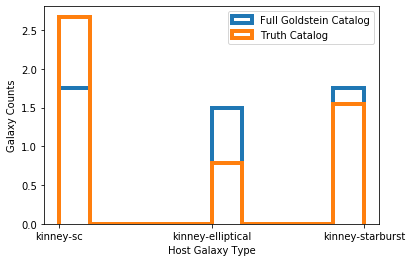

In [12]:
plt.hist(sne_cat_full['host_type'], density=True, histtype='step', lw=4, label='Full Goldstein Catalog')
plt.hist(sne_truth_systems['host_type'], density=True, histtype='step', lw=4, label='Truth Catalog')
plt.xlabel('Host Galaxy Type')
plt.ylabel('Galaxy Counts')
plt.legend()

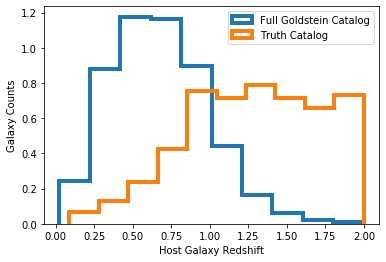

In [13]:
plt.hist(sne_cat_full['z_src'], density=True, histtype='step', lw=4, label='Full Goldstein Catalog')
plt.hist(sne_truth_systems['redshift'], density=True, histtype='step', lw=4, label='Truth Catalog')
plt.xlabel('Host Galaxy Redshift')
plt.ylabel('Galaxy Counts')
plt.legend()

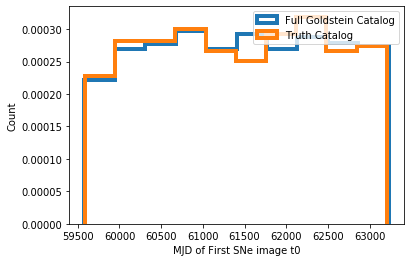

In [14]:
# Check distribution of times SNe appears
plt.hist(sne_cat_full['t0'], density=True, histtype='step', lw=4, label='Full Goldstein Catalog')
plt.hist(sne_truth_systems['t0'], density=True, histtype='step', lw=4, label='Truth Catalog')
plt.xlabel('MJD of First SNe image t0')
plt.ylabel('Count')
plt.legend()

In [15]:
t_delay_img = np.array(list(sne_cat_full['t_delay_img'].values), dtype=np.float)
t_delay_img = t_delay_img[~np.isnan(t_delay_img)]

In [16]:
t_delay_img

array([ 0.        , 11.54860769, 10.11128636, ..., 29.99358718,
        0.        ,  0.36148145])

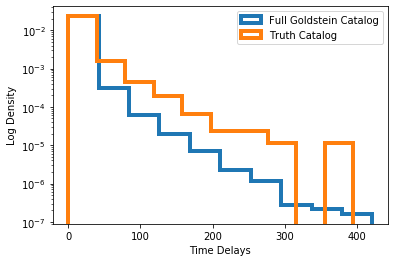

In [17]:
# Check distribution of x0
#plt.hist(sne_cat_full['t_delay_img'], density=True, histtype='step', lw=4, label='Full Goldstein Catalog')
plt.hist(t_delay_img, density=True, histtype='step', lw=4, label='Full Goldstein Catalog')
plt.hist(sne_truth['t_delay'], density=True, histtype='step', lw=4, label='Truth Catalog')
plt.xlabel('Time Delays')
plt.yscale('log')
plt.ylabel('Log Density')
plt.legend()

In [18]:
ids, num_images = np.unique(sne_truth['lens_cat_sys_id'], return_counts=True)

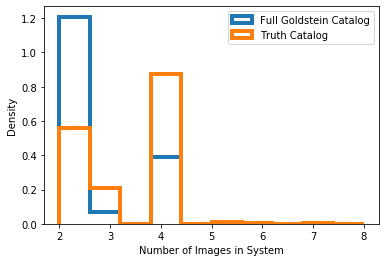

In [19]:
# Check distribution of x0
plt.hist(sne_cat_full['n_img'], density=True, histtype='step', lw=4, label='Full Goldstein Catalog')
plt.hist(num_images, density=True, histtype='step', lw=4, label='Truth Catalog')
plt.xlabel('Number of Images in System')
plt.ylabel('Density')
plt.legend()

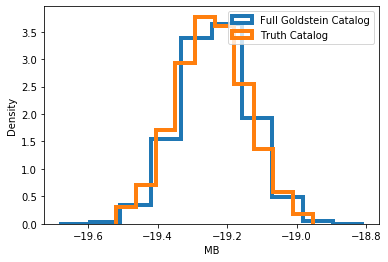

In [20]:
# Check distribution of MB parameter
plt.hist(sne_cat_full['MB'], density=True, histtype='step', lw=4, label='Full Goldstein Catalog')
plt.hist(sne_truth_systems['MB'], density=True, histtype='step', lw=4, label='Truth Catalog')
plt.xlabel('MB')
plt.ylabel('Density')
plt.legend()

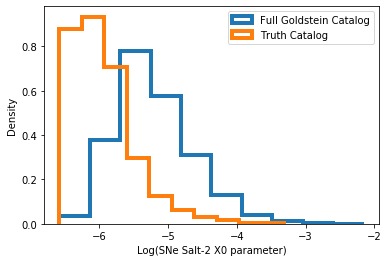

In [21]:
# Check distribution of x0
plt.hist(np.log10(sne_cat_full['x0']), density=True, histtype='step', lw=4, label='Full Goldstein Catalog')
plt.hist(np.log10(sne_truth_systems['x0']), density=True, histtype='step', lw=4, label='Truth Catalog')
plt.xlabel('Log(SNe Salt-2 X0 parameter)')
plt.ylabel('Density')
plt.legend()